In [ ]:
!pip install missingno
!pip install tqdm


In [1]:
import os
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

archivo_csv = 'fact_licitacion-2007_2023-full.csv'
directorio_data = os.path.join('..', '..', 'data')

In [2]:
ruta_archivo = os.path.join(directorio_data, archivo_csv)
df_csv = pd.read_csv(ruta_archivo, encoding="ISO-8859-1", delimiter=",")
df_csv.shape

(12126458, 11)

In [3]:
df = df_csv.copy()

In [4]:
# Convertir 'id_fecha' a formato de fecha y ordenar de forma ascendente
df['id_fecha'] = pd.to_datetime(df['id_fecha'], format='%Y%m%d')
df = df.sort_values(by='id_fecha')

In [5]:
# 1. Crear características de fecha
df['mes'] = df['id_fecha'].dt.month
df['trimestre'] = df['id_fecha'].dt.quarter
df['anio'] = df['id_fecha'].dt.year

In [6]:
# Agrupa y suma la cantidad de productos por zona
nombre_columna_objetivo = 'monto_adjudicado_usd'
df_group = df.groupby(['anio','mes','id_producto'])[nombre_columna_objetivo].sum().reset_index()
df_group

,anio,mes,id_producto,monto_adjudicado_usd
0,2007,1,10101601,2.332242e+02
1,2007,1,10101701,1.465283e+01
2,2007,1,10101901,2.312631e+00
3,2007,1,10121502,2.459899e+01
4,2007,1,10121604,1.062330e+02
...,...,...,...,...
1079538,2023,6,94121513,6.111767e+04
1079539,2023,6,94121802,3.149039e+05
1079540,2023,6,101101001,1.474686e+06
1079541,2023,6,102101001,2.067456e+06


In [7]:
#los valores de cantidades deben ser valores enteros
col_set_int = ['id_producto','mes','anio',nombre_columna_objetivo]

#col_set_int = [nombre_columna_objetivo]

for col in col_set_int:
    antes = df_group[col].dtype
    df_group[col] = df_group[col].astype(int)
    despues = df_group[col].dtype
    print(f'{col} : {antes} -> {despues}')

id_producto : int64 -> int32
mes : int32 -> int32
anio : int32 -> int32
monto_adjudicado_usd : float64 -> int32


In [8]:
df_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1079543 entries, 0 to 1079542
Data columns (total 4 columns):
 #   Column                Non-Null Count    Dtype
---  ------                --------------    -----
 0   anio                  1079543 non-null  int32
 1   mes                   1079543 non-null  int32
 2   id_producto           1079543 non-null  int32
 3   monto_adjudicado_usd  1079543 non-null  int32
dtypes: int32(4)
memory usage: 16.5 MB


In [ ]:
df_group.describe()

In [9]:
df_group = df_group.query(nombre_columna_objetivo + ' >= 0')

In [ ]:
df_group.describe()

In [ ]:
resultados = df_group.groupby('id_producto')[nombre_columna_objetivo].agg(['mean', 'std', 'count'])


In [ ]:
resultados

In [10]:
# Calcula el primer y tercer cuartil (Q1 y Q3) de la columna 'cantidad_adjudicada'
Q1 = df_group[nombre_columna_objetivo].quantile(0.25)
Q3 = df_group[nombre_columna_objetivo].quantile(0.75)

# Calcula el rango intercuartil (IQR)
IQR = Q3 - Q1

# Define un factor multiplicativo para ajustar el umbral (por ejemplo, 1.5 veces el IQR)
factor_umbral = 1.5

# Calcula el valor umbral
umbral = Q3 + factor_umbral * IQR


# Crea una nueva columna llamada 'segmento' en función del valor umbral
df_group['segmento'] = [1 if x < umbral else 2 for x in df_group[nombre_columna_objetivo]]


In [11]:
df_segm_1 = df_group[df_group['segmento'] == 1]
df_segm_2 = df_group[df_group['segmento'] == 2]
print([df_segm_1.shape,df_segm_2.shape])

[(908074, 5), (171417, 5)]


In [ ]:
df_segm_1

In [ ]:

# Supongamos que tienes un DataFrame llamado 'df' y quieres encontrar la fila con el valor máximo en la columna 'monto_adjudicado_usd'
max_index = df_segm_1[nombre_columna_objetivo].idxmax()  # Encuentra el índice del valor máximo
 
# Accede a la fila correspondiente
fila_max = df_segm_1.loc[max_index]
 
# Ahora 'fila_max' contiene la fila con el valor máximo en la columna 'monto_adjudicado_usd'
print(fila_max)

# Borra la fila con el índice encontrado
df_segm_1 = df_segm_1.drop(max_index)

{'whiskers': [<matplotlib.lines.Line2D at 0x25671c81a90>,
 'caps': [<matplotlib.lines.Line2D at 0x25671c81fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x25671c817f0>],
 'medians': [<matplotlib.lines.Line2D at 0x25671c9f550>],
 'fliers': [<matplotlib.lines.Line2D at 0x25671c9f7f0>],
 'means': []}

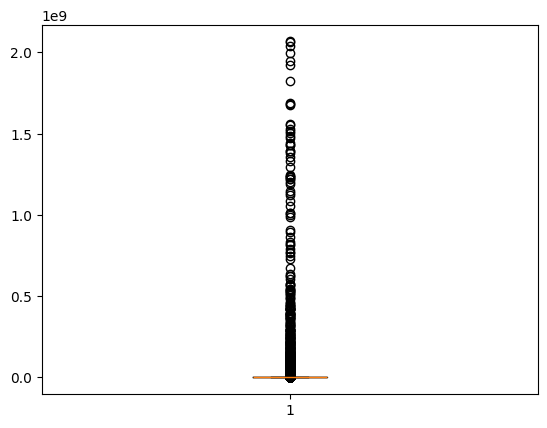

In [12]:
import matplotlib.pyplot as plt
plt.boxplot(df_segm_2[nombre_columna_objetivo])

In [13]:
# Separamos las variables independientes y dependiente
X_df = df_segm_1.drop(columns=[nombre_columna_objetivo,'segmento'])
y_df = df_segm_1[nombre_columna_objetivo]
print(f'X: {X_df.shape} y: {y_df.shape}')

X: (908074, 3) y: (908074,)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f'Tamaño set de entrenamientos: X: {X_train.shape} y: {y_train.shape}')
print(f'Tamaño set de validacion: X: {X_valid.shape} y: {y_valid.shape}')
print(f'Tamaño set de prueba: X: {X_test.shape} y: {y_test.shape}')

Tamaño set de entrenamientos: X: (726459, 3) y: (726459,)
Tamaño set de validacion: X: (90807, 3) y: (90807,)
Tamaño set de prueba: X: (90808, 3) y: (90808,)


In [15]:
score_models = []
X_train_scaled = X_train.copy()
X_valid_scaled = X_valid.copy()
X_test_scaled = X_test.copy()

In [16]:
# Aplicar Min-Max Scaling a las características (X)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [17]:
df_train_scaled = pd.DataFrame(X_train_scaled, columns=[X_train.columns])
df_train_scaled.head()

,anio,mes,id_producto
0,0.6250,0.363636,0.446066
1,0.0625,0.363636,0.189228
2,0.3750,0.818182,0.357514
3,0.2500,0.454545,0.358299
4,0.4375,0.090909,0.467194


### Redes Neuronales

In [ ]:
import keras.backend as K
K.clear_session()

In [ ]:
np.random.seed(461)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

model_nn = keras.Sequential([
    Dense(3, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(6, activation='relu'),
    Dense(1, activation='linear')
])

learning_rate = 0.002
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model_nn.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=["mae"])  # Cambiar la métrica a 'mae'

model_nn.summary()

In [ ]:
#score = model_nn.fit(X_train_scaled, y_train, epochs=50, batch_size=64, verbose=1, shuffle=True)
#score = model_nn.fit(X_train_scaled, y_train, epochs=50,  batch_size=32, validation_data=(X_valid_scaled, y_valid), verbose=1, shuffle=True)
score = model_nn.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_valid_scaled, y_valid), verbose=1, shuffle=True)

In [ ]:
score_models.append(score)
print("SCORE: [%s] " % score)

In [ ]:
model_nn.save('modelo_entrenado.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Carga el modelo desde el archivo guardado
model_nn = load_model('modelo_entrenado.h5')

# Continúa entrenando el modelo
score = model_nn.fit(X_train_scaled, y_train, epochs=700, batch_size=32, validation_data=(X_valid_scaled, y_valid), verbose=1, shuffle=True)


### Regresión Lineal


In [ ]:
np.random.seed(461)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)

score = model_lr.score(X_valid_scaled, y_valid)
score_models.append(score)

predictions = model_lr.predict(X_test)
mse_unidades = mean_squared_error(y_test, predictions)
r2_unidades = r2_score(y_test, predictions)


print("SCORE: [%s] " % score)
print("r2_unidades: [%s] " % r2_unidades)

### Regresión de Máquinas de Soporte Vectorial (SVM)

In [ ]:
np.random.seed(461)
from sklearn.svm import SVR

model_svm = SVR(verbose=1)
model_svm.fit(X_train_scaled, y_train)

score = model_svm.score(X_valid_scaled, y_valid)
score_models.append(score)
print("SCORE: [%s] " % score)

### Regresión de Bosques Aleatorios


In [18]:
np.random.seed(461)
from sklearn.ensemble import RandomForestRegressor

model_RF_Regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=7, verbose=1)
model_RF_Regressor.fit(X_train_scaled, y_train)
score = model_RF_Regressor.score(X_valid_scaled, y_valid)
score_models.append(score)
print("SCORE: [%s] " % score)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   26.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


SCORE: [0.07971631104229981] 


#### Regresion logistica

In [ ]:
np.random.seed(461)
from sklearn.linear_model import LogisticRegression

model_rl = LogisticRegression()
model_rl.fit(X_train_scaled, y_train)
score = model_rl.score(X_valid_scaled, y_valid)
score_models.append(score)
print("SCORE: [%s] " % score)


In [ ]:
print(score_models)

In [ ]:
from sklearn.metrics import r2_score

predictions = model_lr.predict(X_valid_scaled)
r2 = r2_score(y_valid, predictions)
print("R^2 Score: %.2f" % r2)